# Intro

Prophet es una biblioteca de pronóstico de series temporales de Python desarrollada por Facebook. Prophet detecta automáticamente la estacionalidad anual, semanal y diaria. Puede descomponer rápidamente los efectos de tendencia y estacionalidad.

En este tutorial, haremos una predicción de series temporales de los precios de Bitcoin. Se cubrirán los siguientes temas:

- ¿Cómo entrenar un modelo de pronóstico de series de tiempo usando Prophet?
- ¿Cómo hacer predicciones y descomposición de series temporales?
- ¿Cómo identificar puntos de cambio en la tendencia?
- ¿Cómo hacer una validación cruzada de series temporales?
- ¿Cómo evaluar el rendimiento del modelo de series de tiempo usando Prophet?

### Paso 1: instalar e importar bibliotecas

In [1]:
#!pip install yfinance prophet

In [2]:
import numpy as np
import pandas as pd


import yfinance as yf

# Prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# VisualizaCION
import plotly.graph_objs as go

# Paso 2: obtenga datos de precios de Bitcoin

En el segundo paso, los datos del precio de Bitcoin se descargan de la API financiera de Yahoo. Estamos utilizando datos diarios de dos años de 2018 y 2019.

Yahoo Finance descarga datos con la fecha como índice. Usando reset_index, creamos un nuevo índice y usamos la fecha como columna. Esto se debe a que Prophet requiere que la variable de fecha y hora sea una columna para la entrada del modelo.

De forma predeterminada, la fecha es un tipo de cadena, pd.to_datetimela cambia a un formato DateTime.

In [3]:
# Descargar datos Bitcoin
data = yf.download(tickers='BTC-USD', start='2018-01-01', end='2024-03-14', interval = '1d')

# Restablecer el índice y tener la fecha como columna
data.reset_index(inplace=True)

# Cambiar la fecha al formato de fecha y hora
data['Date'] = pd.to_datetime(data['Date'])


data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [4]:
# Declarar la figura
fig = go.Figure()

fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Bitcoin Data'))

*objetivo* pronosticar el precio de cierre de Bitcoin. Prophet toma dos columnas como entradas, una columna de fecha y hora llamada "ds" y una columna de valor llamada "y". Por lo tanto, debemos eliminar todas las demás columnas, cambiar el nombre de "Fecha" a "ds" y "Cerrar" a "y".


In [5]:
# # Mantener solo la fecha y el precio de cierre
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Cambiar el nombre de la fecha a ds y cerrar el precio a y
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

df.head()

,ds,y
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000
3,2018-01-04,15599.200195
4,2018-01-05,17429.500000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2264 non-null   datetime64[ns]
 1   y       2264 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.5 KB


# Paso 3: Train Test Split

crear un conjunto de datos de entrenamiento y de prueba. No podemos utilizar la división aleatoria para los datos de series temporales porque provoca una fuga de datos de fechas futuras a fechas pasadas. Por lo general, se selecciona una fecha límite. Los datos anteriores a la fecha límite son el conjunto de datos de entrenamiento y los datos posteriores a la fecha límite se utilizan como conjunto de datos de prueba.

En este ejemplo, se utiliza '2024–03–14' como fecha límite. Los primeros 23 meses se utilizan para la capacitación del modelo y el último mes se usa para pruebas.

In [7]:
# Train test split
df_train = df[df['ds']<='2024-02-29']
df_test = df[df['ds']>'2024-02-29']

# Print .
print('El conjunto de datos de entrenamiento tiene', len(df_train), 'que, van desde', df_train['ds'].min(), 'hasta', df_train['ds'].max())
print(' El conjunto de datos de prueba tiene', len(df_test), 'que, van desde', df_test['ds'].min(), 'hasta', df_test['ds'].max())

El conjunto de datos de entrenamiento tiene 2251 que, van desde 2018-01-01 00:00:00 hasta 2024-02-29 00:00:00
 El conjunto de datos de prueba tiene 13 que, van desde 2024-03-01 00:00:00 hasta 2024-03-13 00:00:00


In [8]:
df_test

,ds,y
2251,2024-03-01,62440.632812
2252,2024-03-02,62029.847656
2253,2024-03-03,63167.371094
2254,2024-03-04,68330.414062
2255,2024-03-05,63801.199219
2256,2024-03-06,66106.804688
2257,2024-03-07,66925.484375
2258,2024-03-08,68300.093750
2259,2024-03-09,68498.882812
2260,2024-03-10,69019.789062


## Paso 4: Entrene el modelo de series temporales con Prophet


Entrenar el modelo de series de tiempo utilizando el conjunto de datos de entrenamiento.

- `interval_width` especifica el intervalo de predicción. Cambiamos el valor predeterminado del intervalo de predicción del 80% al 95%. Hace que el límite superior y el límite inferior de la predicción sean más amplios.

- `n_changepoints` es el número de puntos de cambio en la tendencia de la serie temporal. El valor predeterminado es 25. Según la forma de los datos del precio de Bitcoin, se estableció en 7.

In [9]:
# Crea el modelo con una confianza interna del 95%
m = Prophet(interval_width=0.95, n_changepoints=7)

# Ajusta el modelo
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpa50yce/08_sk91d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpa50yce/e4_o0h86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33133', 'data', 'file=/tmp/tmpfpa50yce/08_sk91d.json', 'init=/tmp/tmpfpa50yce/e4_o0h86.json', 'output', 'file=/tmp/tmpfpa50yce/prophet_model0s7vbtq_/prophet_model-20240316052659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:26:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


La estacionalidad anual y la estacionalidad diaria se desactivan automáticamente. Esto se debe a que Prophet detecta que el conjunto de datos que estamos utilizando no tiene varios años completos de datos y no tiene unidades menores a un día

# Paso 5: utilice el modelo Prophet para hacer predicciones


El paso 5 utiliza el modelo Profeta entrenado para hacer la predicción. Usamos los últimos 31 días para crear el marco de datos futuro. Esto es lo mismo que usar el conjunto de datos de prueba que creamos anteriormente.

El resultado de la predicción contiene mucha información. Mantuvimos el valor predicho yhaty su valor límite superior e inferior del intervalo de predicción.

In [20]:
# Crear un marco de datos futuro para la predicción
future = m.make_future_dataframe(periods=14)

# Pronosticar los valores futuros del marco de datos
forecast = m.predict(future)

# Verifique los valores pronosticados y el pronóstico del límite
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
2250,2024-02-29,47387.521826,37092.544412,58228.129667
2251,2024-03-01,47274.995341,36625.008864,56942.293005
2252,2024-03-02,47202.376164,36819.510919,58046.014527
2253,2024-03-03,47104.498202,36976.045200,58011.247711
2254,2024-03-04,47073.883489,36275.279219,57687.288313
2255,2024-03-05,47012.690276,35983.119502,58177.027364
2256,2024-03-06,47035.269274,37120.705771,57152.675675
2257,2024-03-07,46908.637727,36477.642628,56918.630709
2258,2024-03-08,46885.234182,36419.680737,57183.530215
2259,2024-03-09,46921.416704,37082.191780,57053.681464


El eje x es la fecha en la visualización del pronóstico y el eje y es el precio de cierre de Bitcoin. Los puntos negros son los precios reales en el conjunto de datos de entrenamiento y los puntos rojos son los precios reales previstos. La línea azul es la predicción del modelo de series temporales. El área sombreada es el intervalo de predicción del 95%

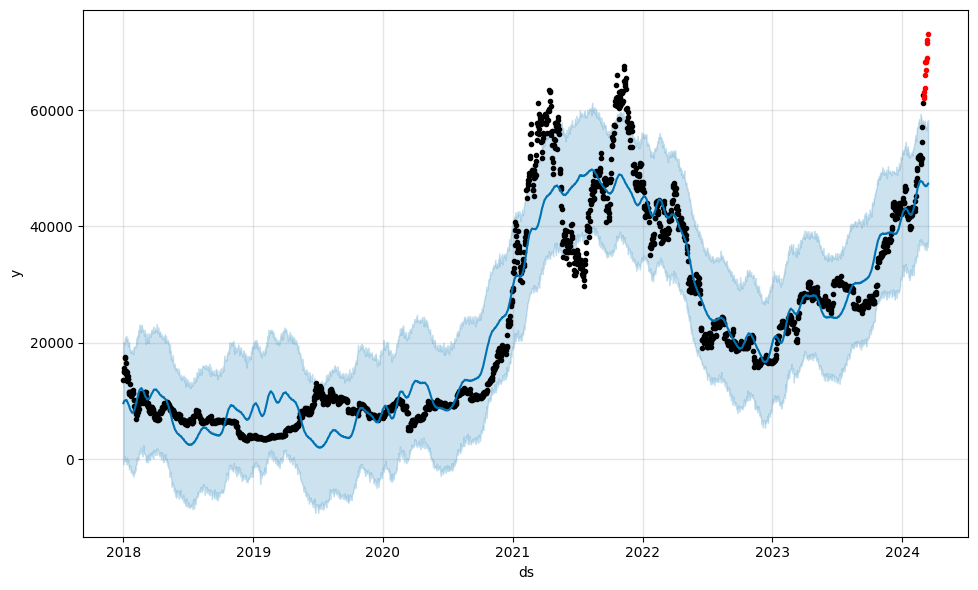

In [21]:
# Visualizar el pronostico
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

#Paso 6: Descomposición de series temporales



En el paso 6, descompondremos el pronóstico de la serie temporal.

-
-

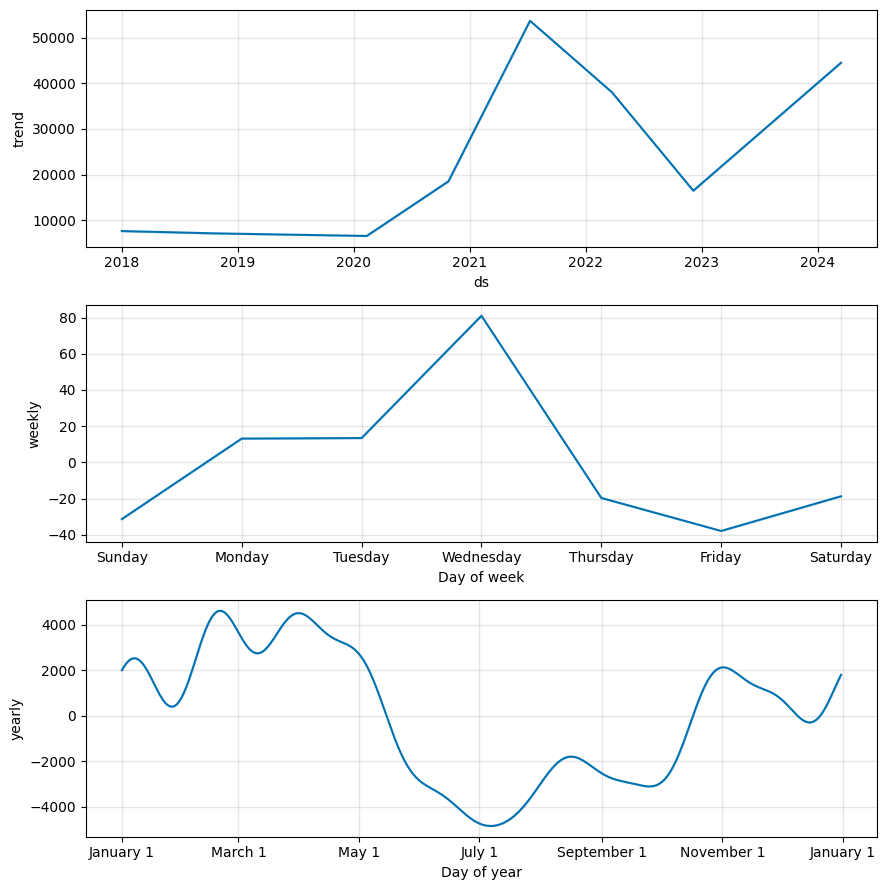

In [22]:
# Visualizar las componentes
m.plot_components(forecast);

# Paso 7: identificar los puntos de cambio


Paso 7, cómo identificar los puntos de cambio en la tendencia de la serie temporal.

Prophet identifica automáticamente los puntos de cambio en los datos de series temporales siguiendo los pasos a continuación:

- Utilice los datos del primer 80% de la serie temporal para identificar puntos de cambio. El valor predeterminado es 80% pero es un hiperparámetro que podemos cambiar.
- Identificar un gran número de fechas distribuidas uniformemente con posibles cambios de trayectoria.
- Aplique un previo escaso a las magnitudes de la tasa de cambio, que es similar a la regularización L1.
Podemos listar las fechas correspondientes a los puntos de cambio usando `.changepoints`.


In [23]:
# Puntos de cambio predeterminados
print(f'Hay {len(m.changepoints)} puntos de cambio. \n Los puntos de cambio soon \n{df.loc[df["ds"].isin(m.changepoints)]}')

Hay 7 puntos de cambio. 
 Los puntos de cambio soon 
             ds             y
257  2018-09-15   6543.200195
514  2019-05-30   8319.472656
771  2020-02-11  10208.236328
1028 2020-10-25  13031.173828
1285 2021-07-09  33798.011719
1542 2022-03-23  42892.957031
1799 2022-12-05  16974.826172


En la visualización, las líneas de puntos rojas representan los puntos de cambio. No incluye los siete puntos de cambio del gráfico. Sólo se incluyen los que tienen más cambios.

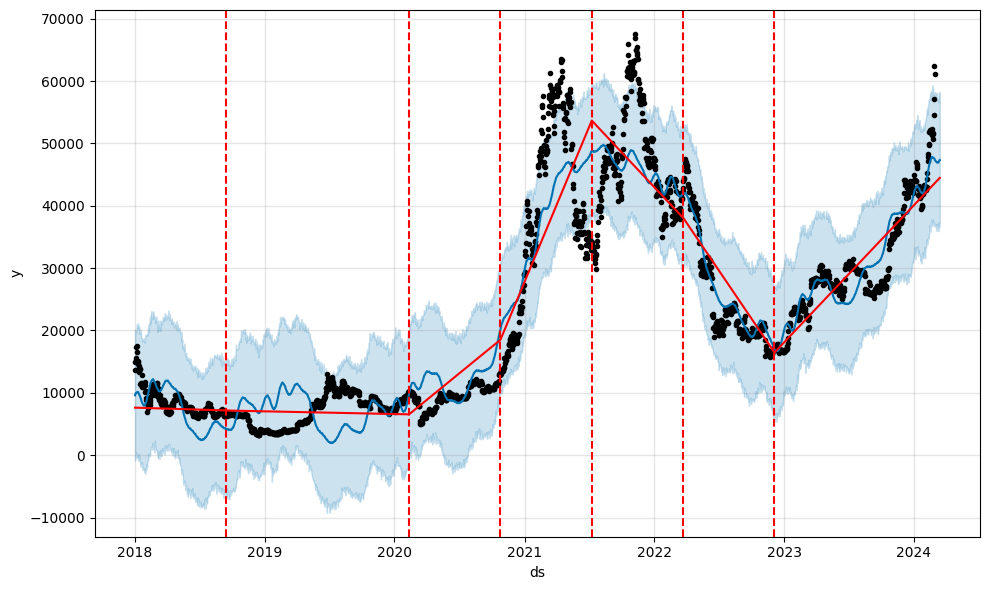

In [24]:

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Paso 8: validación cruzada


Paso 8, realizar validación cruzada del modelo de series de tiempo. Prophet tiene una cross_validation función para automatizar la comparación entre los valores reales y previstos.

- `m` es el modelo entrenado.
- `initial='500 days'` significa que el modelo inicial se entrenará en los primeros 500 días de datos.
- `period='60 days'` significa que se agregarán 60 días al conjunto de datos de entrenamiento para cada modelo adicional.
- `horizon = '30 days'`significa que el modelo pronostica los próximos 30 días. Cuando horizonse proporciona solo, el valor predeterminado de Prophet initiales el triple de horizon, y period la mitad de horizon.
- `parallel="processes"` permite el procesamiento paralelo para la validación cruzada. Cuando la validación cruzada paralela se pueda realizar en una sola máquina, processesproporcione el mayor rendimiento. Para problemas más grandes, daskse puede utilizar para realizar una validación cruzada en varias máquinas.




In [25]:
# Cross validation
df_cv = cross_validation(m, initial='500 days', period='60 days', horizon = '30 days', parallel="processes")
df_cv.head()

INFO:prophet:Making 29 forecasts with cutoffs between 2019-06-25 00:00:00 and 2024-01-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7eb47d4535e0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpa50yce/27iod1px.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpa50yce/m6pn4ivw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpa50yce/8yiztq1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpa50yce/pzqqit6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65242', 'data', 'file=/tmp/tmpfpa50yce/m6pn4ivw.json', 'init=/tmp/tmpfpa50yce/pzqqit6r.json', 'output', 'file=/tmp/tmpfpa50yce/prophet_modeluuqx9dpd/prophet_model-20240316053156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:31:56 - cmdstanpy - INFO 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-26,9018.708568,7675.013215,10311.216416,13016.231445,2019-06-25
1,2019-06-27,9025.348175,7720.046087,10306.090204,11182.806641,2019-06-25
2,2019-06-28,9115.589202,7782.289766,10453.957323,12407.332031,2019-06-25
3,2019-06-29,9222.767821,7941.116144,10539.874243,11959.371094,2019-06-25
4,2019-06-30,9246.169256,7877.422958,10752.157894,10817.155273,2019-06-25


# Paso 9: Evaluación del desempeño del modelo Prophet


El paso 9 evalúa el desempeño del modelo de validación cruzada.

- MSE (Error cuadrático medio) resume la diferencia al cuadrado entre lo real y la predicción y se divide por el número de predicciones.
- RMSE (error cuadrático medio) toma la raíz cuadrada de MSE.
- MAE (error absoluto medio) resume la diferencia absoluta entre lo real y la predicción y se divide por el número de predicciones.
- MAPE (Error porcentual absoluto medio) resume la diferencia porcentual absoluta entre lo real y la predicción y se divide por el número de predicciones. MAPE es independiente de la magnitud de los datos, por lo que puede usarse para comparar diferentes pronósticos. Pero no está definido cuando el valor real es cero.
- MDAPE (Error porcentual absoluto medio) es similar a MAPE. La diferencia es que calcula la mediana en lugar de tomar el promedio de la diferencia porcentual absoluta.
- SMAPE (Error porcentual absoluto medio simétrico) es similar a MAPE. La diferencia es que al calcular el error porcentual absoluto, el denominador es el valor real de MAPE y el promedio del valor real y previsto de SMAPE.

In [27]:
df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,4.248344e+07,6517.931864,4787.665494,0.170656,0.138239,0.183520,0.770115
1,4 days,5.065833e+07,7117.466572,5205.448628,0.182395,0.145228,0.194642,0.758621
2,5 days,5.899871e+07,7681.062087,5586.049249,0.194317,0.148279,0.205827,0.701149
3,6 days,6.458457e+07,8036.452827,5811.814670,0.203595,0.156059,0.213930,0.655172
4,7 days,7.282479e+07,8533.744258,6061.893517,0.212267,0.158622,0.220991,0.597701


`plot_cross_validation_metric` El método de Prophet nos ayuda a trazar los resultados del rendimiento de la validación cruzada.

- El eje $x$ es el horizonte. Como establecimos el horizonte en 30 días, el eje x tiene un valor de hasta 30.
- El eje y es la métrica que nos interesa. La utilizamos mapecomo ejemplo en esta visualización.
- Cada día podemos ver tres puntos. Esto se debe a que hay tres modelos en la validación cruzada y cada punto representa el MAPE de un modelo.
- La línea es el rendimiento agregado de todos los modelos. Podemos ver que el valor MAPE aumenta con los días, lo cual es de esperarse porque las series de tiempo tienden a hacer mejores predicciones para el futuro cercano que para el futuro lejano.

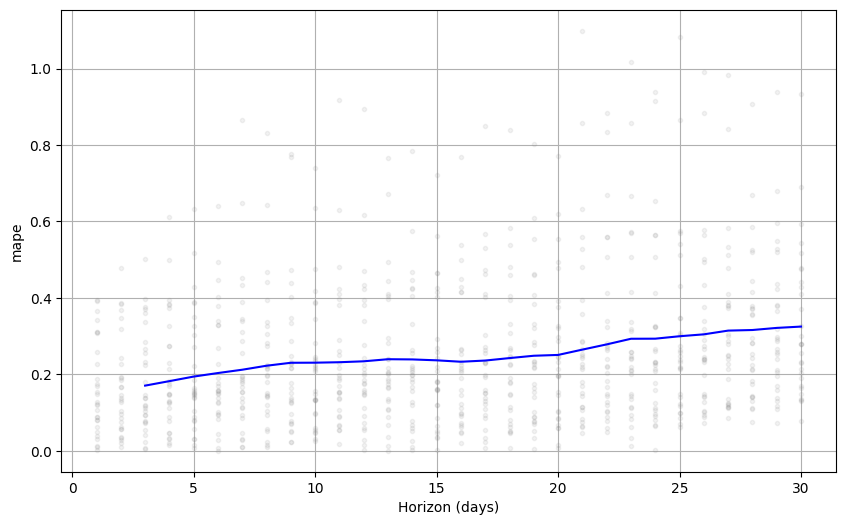

In [28]:
#
fig = plot_cross_validation_metric(df_cv, metric='mape')

# Reference

* [Prophet documentation](https://facebook.github.io/prophet/docs/quick_start.html)
* [Prophet cross-validation and hyperparameter tuning](https://facebook.github.io/prophet/docs/diagnostics.html)
* [Prophet change point detection](https://facebook.github.io/prophet/docs/trend_changepoints.html)
